# Music

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from music revisions and music items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/music_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/music.csv')

In [3]:
print("Number of Revisions in Music Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Music Dataset")
print(items.shape)

Number of Revisions in Music Dataset
(177721, 12)
Number of Wikidata Items in Music Dataset
(49476, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(177721, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    49418.000000
mean         3.580558
std          4.254567
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max        314.000000
Name: qid, dtype: float64

In [16]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [17]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
11262
Items with No of Edits = 2
13227
Items with No of Edits = 3
6592
Items with No of Edits = 4
6277
Items with No of Edits = 5
3827
Items with No of Edits <= 5
41185


In [18]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [19]:
df_editscount.shape

(8233, 2)

In [20]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [21]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [22]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [23]:
print(df_editscount.head())
print(df_editscount[df_editscount['qid'] == 'Q4115189'])
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

        qid  editscount
0   Q132190         314
1   Q263696         168
2   Q130311         152
3  Q6031433         147
4   Q108941         144
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []


In [24]:
print("Number of Revisions in Music Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Music Dataset after Data Cleaning")
music_items = rev['qid'].value_counts()
print(music_items.shape)

Number of Revisions in Music Dataset after Data Cleaning
(75209, 10)
Number of Wikidata Items in Music Dataset after Data Cleaning
(8233,)


# Descriptive Statistics

In [25]:
print(music_items.describe().astype(int))

count    8233
mean        9
std         7
min         6
25%         6
50%         7
75%         9
max       314
Name: qid, dtype: int32


In [26]:
# converting a series to a dataframe
m_items = pd.DataFrame({'type':music_items.index, 'count':music_items.values})

In [27]:
# Items between the median and 75th percentile
print(m_items[(m_items['count'] >= 7) & (m_items['count'] < 9)])
# Items in the top 25% of the dataset
print(m_items[m_items['count'] >= 9])
# Items below median that is items that fall in the fist 50%
print(m_items[m_items['count'] < 7])
# Items that form the low 25% of the dataset
print(m_items[m_items['count'] < 6])
# Items that are part of 75% of the dataset
print(m_items[m_items['count'] < 9])

           type  count
2683  Q19939491      8
2684   Q2319135      8
2685    Q272203      8
2686  Q16050347      8
2687    Q283385      8
...         ...    ...
5412   Q6289925      7
5413    Q129252      7
5414    Q234037      7
5415   Q4756875      7
5416   Q1501423      7

[2734 rows x 2 columns]
           type  count
0       Q132190    314
1       Q263696    168
2       Q130311    152
3      Q6031433    147
4       Q108941    144
...         ...    ...
2678   Q2212507      9
2679  Q27651510      9
2680    Q266617      9
2681  Q27894007      9
2682   Q2448688      9

[2683 rows x 2 columns]
          type  count
5417  Q1281090      6
5418  Q1584098      6
5419   Q548160      6
5420   Q588392      6
5421     Q8876      6
...        ...    ...
8228   Q231492      6
8229   Q668141      6
8230  Q4371210      6
8231  Q3595475      6
8232  Q3177166      6

[2816 rows x 2 columns]
Empty DataFrame
Columns: [type, count]
Index: []
           type  count
2683  Q19939491      8
2684   Q231913

# Statistics for Proxies

In [28]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [29]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

         count
type          
create   32125
add      28946
update    7053
set       3381
remove    2670
revert     496
undo       318
merge      109
restore    103
protect      8


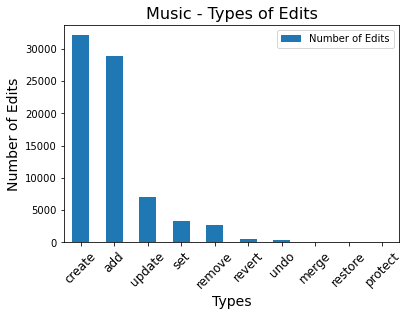

In [30]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Music - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [31]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[4, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

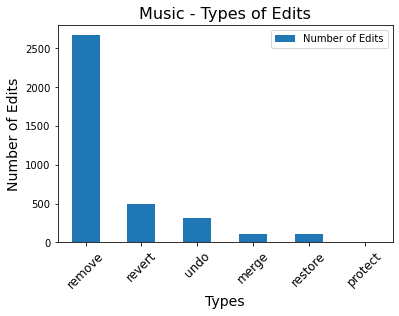

In [32]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Music - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [33]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
revert     496
undo       318
merge      109
restore    103
protect      8


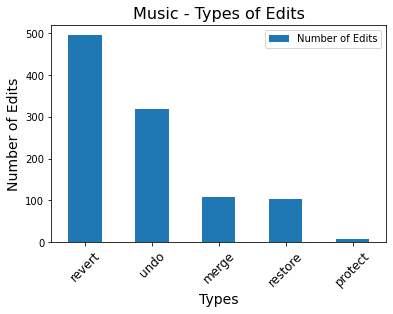

In [35]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Music - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [36]:
no_of_edits = music_items.to_numpy()

(array([6.262e+03, 1.010e+03, 4.080e+02, 1.880e+02, 1.270e+02, 5.900e+01,
        3.700e+01, 3.400e+01, 1.800e+01, 1.500e+01, 9.000e+00, 9.000e+00,
        8.000e+00, 4.000e+00, 7.000e+00, 3.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

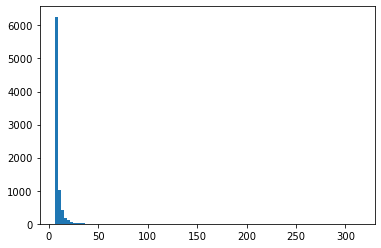

In [37]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

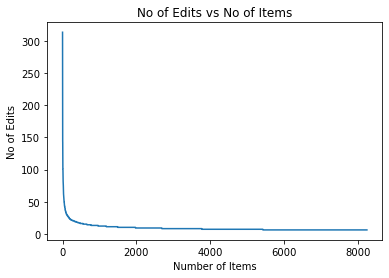

In [38]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [39]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [40]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [41]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [45]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [46]:
proxies = proxies.reset_index()

In [47]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [48]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [49]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [50]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [51]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [52]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000
mean,0.060245,0.013239,0.038625,0.012511,0.000972,0.324305,9.135066,3.854002
std,0.498555,0.117450,0.489903,0.146099,0.031159,0.869672,7.958742,2.522265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000
max,21.000000,2.000000,31.000000,4.000000,1.000000,17.000000,314.000000,52.000000


Text(0, 0.5, 'No of Edits')

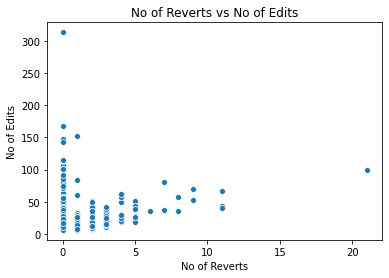

In [53]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

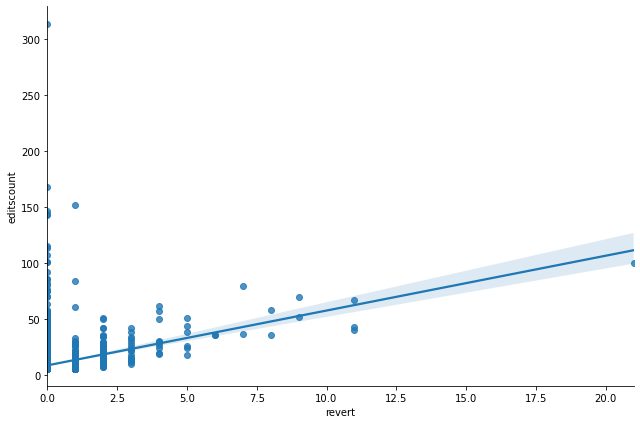

In [54]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [55]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.023719,0.165543,0.521668,0.238648,0.139567,0.306704,0.288883
merge,0.023719,1.000000,0.081893,0.025743,-0.003516,0.073320,0.090226,0.080337
undo,0.165543,0.081893,1.000000,0.134117,0.045289,0.196412,0.303616,0.226448
restore,0.521668,0.025743,0.134117,1.000000,0.397603,0.150674,0.231312,0.197474
protect,0.238648,-0.003516,0.045289,0.397603,1.000000,0.131822,0.161123,0.116186
remove,0.139567,0.073320,0.196412,0.150674,0.131822,1.000000,0.406147,0.344283
editscount,0.306704,0.090226,0.303616,0.231312,0.161123,0.406147,1.000000,0.534273
userscount,0.288883,0.080337,0.226448,0.197474,0.116186,0.344283,0.534273,1.000000


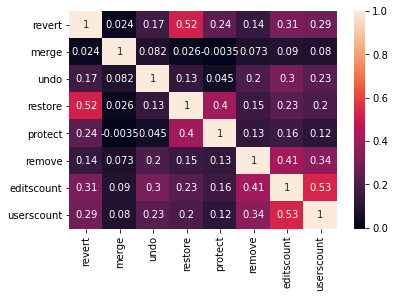

In [56]:
sns.heatmap(corr_matrix, annot=True)

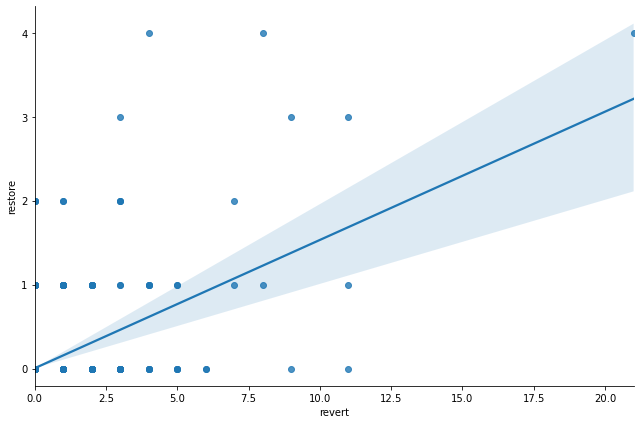

In [57]:
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

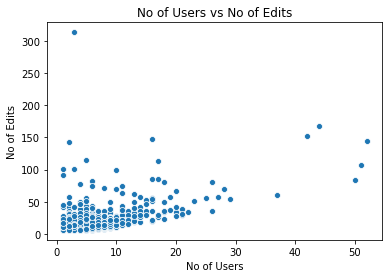

In [58]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

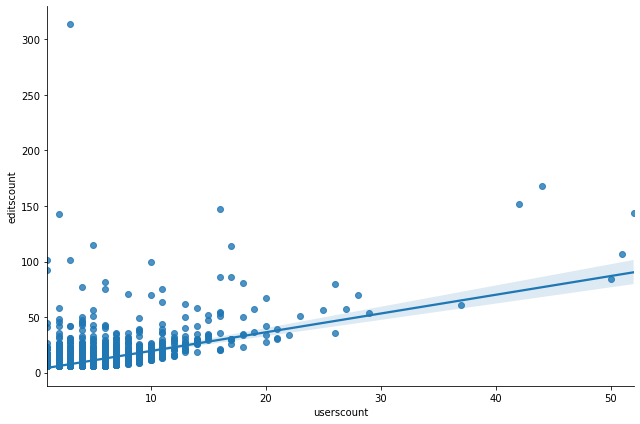

In [59]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [60]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [61]:
proxies.shape

(1901, 9)

In [62]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
19,Q2185544,0,0,0,0,0,1,8,4
25,Q2209749,0,0,0,0,0,3,8,3
46,Q2283905,0,0,0,0,0,1,7,5
53,Q2295154,0,0,0,0,0,1,6,4
66,Q2329648,0,0,0,0,0,3,10,3
...,...,...,...,...,...,...,...,...,...
8204,Q28054755,0,0,0,0,0,1,9,2
8211,Q28057494,0,0,0,0,0,2,8,2
8212,Q28057511,0,0,0,0,0,1,28,8
8216,Q28061388,0,0,0,0,0,2,27,3


In [63]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [64]:
proxies_without_remove.shape

(477, 9)

In [65]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.254298,0.012816,0.431222,0.204739,0.094472,0.325370,0.224461
merge,-0.254298,1.000000,-0.074166,-0.156986,-0.068672,-0.039374,-0.072784,-0.158440
undo,0.012816,-0.074166,1.000000,0.027340,0.005640,0.275647,0.379374,0.203471
restore,0.431222,-0.156986,0.027340,1.000000,0.380412,0.170957,0.239608,0.134792
protect,0.204739,-0.068672,0.005640,0.380412,1.000000,0.211683,0.213062,0.122870
remove,0.094472,-0.039374,0.275647,0.170957,0.211683,1.000000,0.673494,0.476742
editscount,0.325370,-0.072784,0.379374,0.239608,0.213062,0.673494,1.000000,0.793159
userscount,0.224461,-0.158440,0.203471,0.134792,0.122870,0.476742,0.793159,1.000000


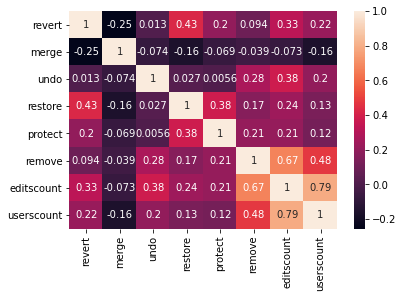

In [66]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Reverts

In [67]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [68]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2480,Q4120122,21,0,1,4,0,4,100,10
343,Q1203,11,0,2,1,0,0,67,20
1291,Q550067,11,0,2,3,1,1,43,5
7551,Q18222476,11,0,1,0,0,4,40,13
363,Q2831,9,0,0,0,0,5,70,28
4427,Q26690130,9,0,2,3,0,2,52,15
2208,Q3626966,8,0,0,1,1,0,36,12
4038,Q17198340,8,0,1,4,0,5,58,14
802,Q132952,7,0,1,1,0,0,37,9
4044,Q17306112,7,0,3,2,0,2,80,26


In [69]:
revert_item_labels = ['Ruggero Pasquarelli', 'John Lennon', 'Niurka Marcos', 'Sofia Carson', 'Michael Jackson',
                     'Anuel AA', 'Harry Styles', 'Shawn Mendes', 'Adam Sandler', 'Tyler Joseph', 
                     'Shakira', 'Will Smith', 'Elvis Presley', 'Marilyn Monroe', 'Camila Cabello', 
                     'Kevin Roldán', 'Cara Delevingne', 'Park Ji-min', 'Iggy Azalea', 'Sasha Grey']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [70]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
2480,Q4120122,Ruggero Pasquarelli,21,0,1,4,0,4,100,10
343,Q1203,John Lennon,11,0,2,1,0,0,67,20
1291,Q550067,Niurka Marcos,11,0,2,3,1,1,43,5
7551,Q18222476,Sofia Carson,11,0,1,0,0,4,40,13
363,Q2831,Michael Jackson,9,0,0,0,0,5,70,28
4427,Q26690130,Anuel AA,9,0,2,3,0,2,52,15
2208,Q3626966,Harry Styles,8,0,0,1,1,0,36,12
4038,Q17198340,Shawn Mendes,8,0,1,4,0,5,58,14
802,Q132952,Adam Sandler,7,0,1,1,0,0,37,9
4044,Q17306112,Tyler Joseph,7,0,3,2,0,2,80,26


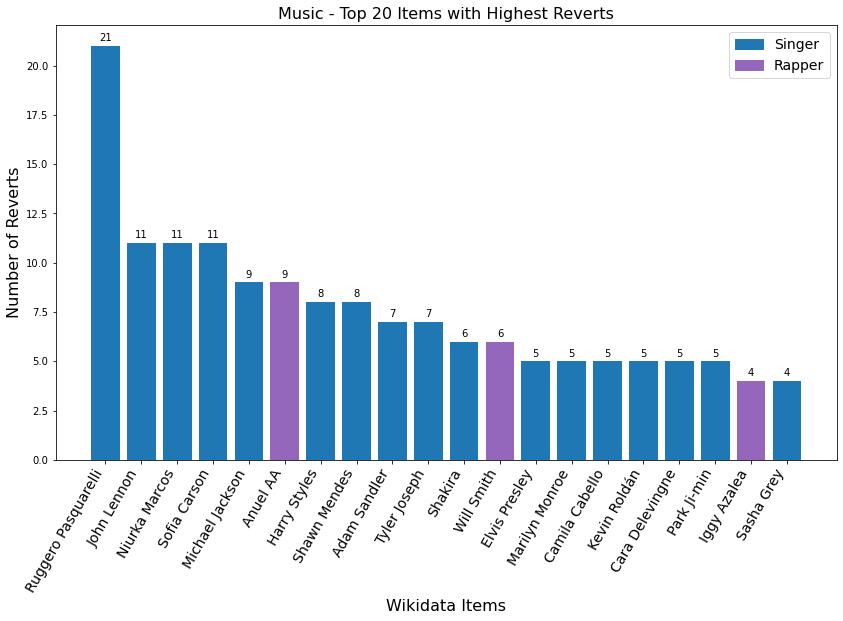

In [71]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.25, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:purple', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:blue']

singer = mpatches.Patch(color='tab:blue', label='Singer')
rapper = mpatches.Patch(color='tab:purple', label='Rapper')

plt.legend(handles=[singer, rapper], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Music - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [72]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [73]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
1042,Q488828,0,2,0,0,0,0,10,2
3862,Q16173210,0,2,0,0,0,0,14,9
4571,Q2898233,0,2,0,0,0,1,25,6
13,Q2165781,0,1,0,0,0,0,7,2
28,Q2227571,0,1,1,0,0,5,15,4
394,Q9535,1,1,0,1,0,0,20,13
496,Q41180,0,1,0,0,0,6,31,7
528,Q46677,2,1,0,0,0,1,22,11
569,Q54885,1,1,0,0,0,2,17,8
654,Q80938,0,1,31,0,0,6,114,17


In [74]:
merge_item_labels = ['Kim Hyun-joo', 'Kim Seolhyun', 'Roni Dalumi', 'Kátia Aveiro', 'Keith St John',
                     'Shah Rukh Khan', 'La Marseillaise', 'Melissa Benoist', 'Jean Ferrat', 'John Travolta', 
                     'Carl Blum', 'Lita Ford', 'Zdravljica', 'Kim Jae-joong', 'Jo Han-seon', 
                     'Jeon Bo-ram', 'Ubi caritas', 'Thunder', 'Machine Gun Kelly', 'Mako Ishino']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [75]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
1042,Q488828,Kim Hyun-joo,0,2,0,0,0,0,10,2
3862,Q16173210,Kim Seolhyun,0,2,0,0,0,0,14,9
4571,Q2898233,Roni Dalumi,0,2,0,0,0,1,25,6
13,Q2165781,Kátia Aveiro,0,1,0,0,0,0,7,2
28,Q2227571,Keith St John,0,1,1,0,0,5,15,4
394,Q9535,Shah Rukh Khan,1,1,0,1,0,0,20,13
496,Q41180,La Marseillaise,0,1,0,0,0,6,31,7
528,Q46677,Melissa Benoist,2,1,0,0,0,1,22,11
569,Q54885,Jean Ferrat,1,1,0,0,0,2,17,8
654,Q80938,John Travolta,0,1,31,0,0,6,114,17


Text(0.5, 1.0, 'Music - Top 20 Items with Highest Merges')

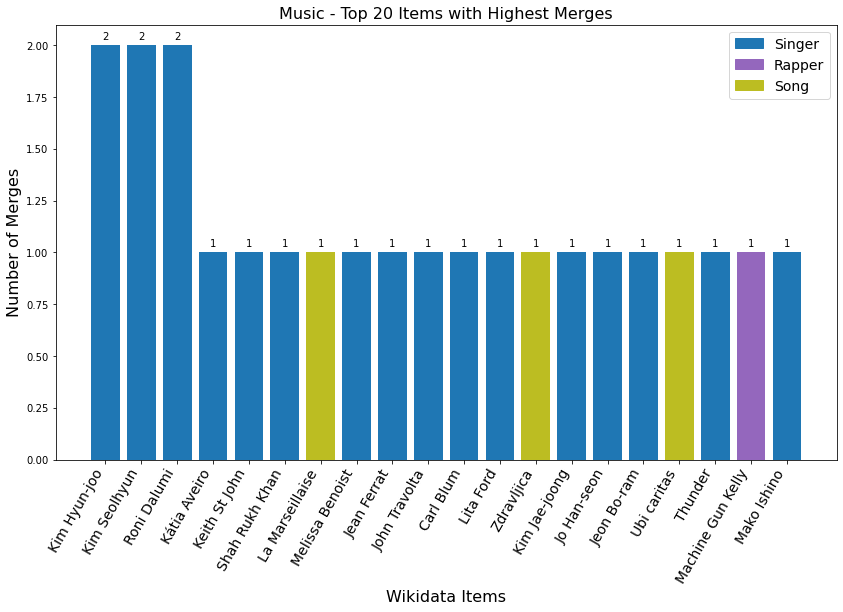

In [76]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.03, str(r), horizontalalignment='center')
    

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:olive', 'tab:blue', 'tab:purple', 'tab:blue']

singer = mpatches.Patch(color='tab:blue', label='Singer')
rapper = mpatches.Patch(color='tab:purple', label='Rapper')
song = mpatches.Patch(color='tab:olive', label='Song')

plt.legend(handles=[singer, rapper, song], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Music - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [77]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [78]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
654,Q80938,0,1,31,0,0,6,114,17
1295,Q550778,0,0,13,0,0,6,64,11
5469,Q276181,0,0,10,0,0,3,20,7
6057,Q439315,0,0,8,0,0,0,11,3
6706,Q1075796,0,0,8,0,0,1,12,4
1431,Q658690,0,0,7,0,0,0,13,4
1085,Q498019,0,0,6,0,0,8,27,11
3893,Q16211162,2,0,6,0,0,1,42,14
7971,Q27553960,0,0,6,1,0,11,46,4
82,Q2347009,1,0,5,0,0,0,12,4


In [79]:
undo_item_labels = ['John Travolta', 'John de Lancie', 'Jim Varney', 'Jemaine Clement', 'Carlos Alazraqui',
                     'Charles Fleischer', 'Richard Simmons', 'Melanie Martinez', 'Meysam Ebrahimi', 'Steve Harvey ', 
                     'Carrie Fisher', 'Fred Rogers', 'Susanne Blakeslee', 'Malena Valentina Ratner', 'David Bowie', 
                     'Daniel Radcliffe', 'Sasha Grey', 'Lady Gaga', 'singer', 'Rabeh Saqer']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [80]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
654,Q80938,John Travolta,0,1,31,0,0,6,114,17
1295,Q550778,John de Lancie,0,0,13,0,0,6,64,11
5469,Q276181,Jim Varney,0,0,10,0,0,3,20,7
6057,Q439315,Jemaine Clement,0,0,8,0,0,0,11,3
6706,Q1075796,Carlos Alazraqui,0,0,8,0,0,1,12,4
1431,Q658690,Charles Fleischer,0,0,7,0,0,0,13,4
1085,Q498019,Richard Simmons,0,0,6,0,0,8,27,11
3893,Q16211162,Melanie Martinez,2,0,6,0,0,1,42,14
7971,Q27553960,Meysam Ebrahimi,0,0,6,1,0,11,46,4
82,Q2347009,Steve Harvey,1,0,5,0,0,0,12,4


Text(0.5, 1.0, 'Music - Top 20 Items with Highest Undos')

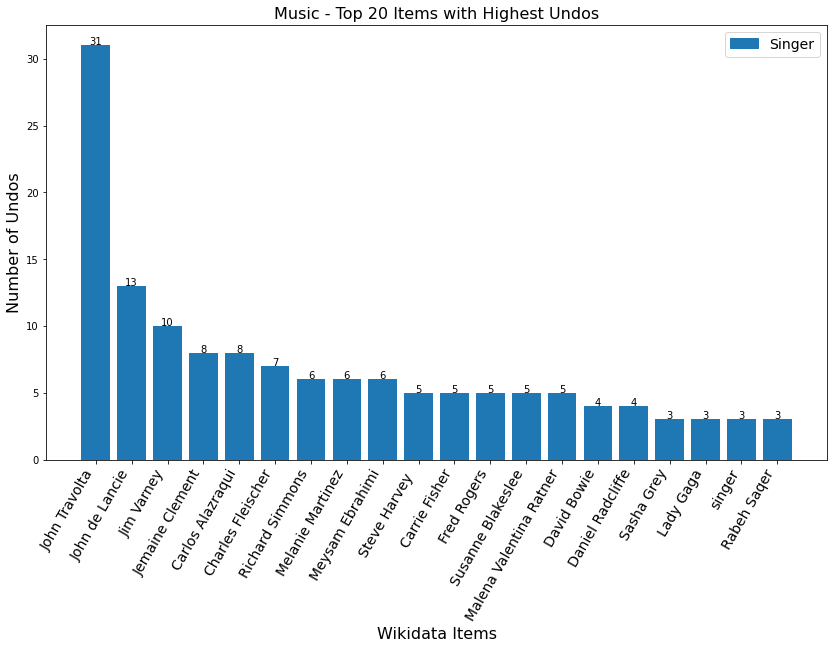

In [82]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

singer = mpatches.Patch(color='tab:blue', label='Singer')

plt.legend(handles=[singer], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Music - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [83]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [84]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
432,Q19848,4,0,3,4,1,4,50,13
2480,Q4120122,21,0,1,4,0,4,100,10
4038,Q17198340,8,0,1,4,0,5,58,14
1291,Q550067,11,0,2,3,1,1,43,5
4427,Q26690130,9,0,2,3,0,2,52,15
4964,Q212772,3,0,0,3,1,2,39,9
438,Q23215,3,0,2,2,0,1,23,11
664,Q83287,3,0,0,2,1,2,32,12
3704,Q13560423,1,0,1,2,0,3,18,11
4044,Q17306112,7,0,3,2,0,2,80,26


In [85]:
restore_item_labels = ['Lady Gaga', 'Ruggero Pasquarelli', 'Shawn Mendes', 'Niurka Marcos', 'Anuel AA',
                     'Cheryl', 'Adele', 'Selena Gomez', 'Dove Cameron', 'Tyler Joseph', 
                     'Mike Myers', 'Bobby Darin', 'Stephen, The King', 'Bertín Osborne', 'Ninel Conde', 
                     'Miriam Bryant', 'Harun Tekin', 'Nadia Di Cello', 'Liam Payne', 'Ahmed Cherif']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [86]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
432,Q19848,Lady Gaga,4,0,3,4,1,4,50,13
2480,Q4120122,Ruggero Pasquarelli,21,0,1,4,0,4,100,10
4038,Q17198340,Shawn Mendes,8,0,1,4,0,5,58,14
1291,Q550067,Niurka Marcos,11,0,2,3,1,1,43,5
4427,Q26690130,Anuel AA,9,0,2,3,0,2,52,15
4964,Q212772,Cheryl,3,0,0,3,1,2,39,9
438,Q23215,Adele,3,0,2,2,0,1,23,11
664,Q83287,Selena Gomez,3,0,0,2,1,2,32,12
3704,Q13560423,Dove Cameron,1,0,1,2,0,3,18,11
4044,Q17306112,Tyler Joseph,7,0,3,2,0,2,80,26


Text(0.5, 1.0, 'Music - Top 20 Items with Highest Restores')

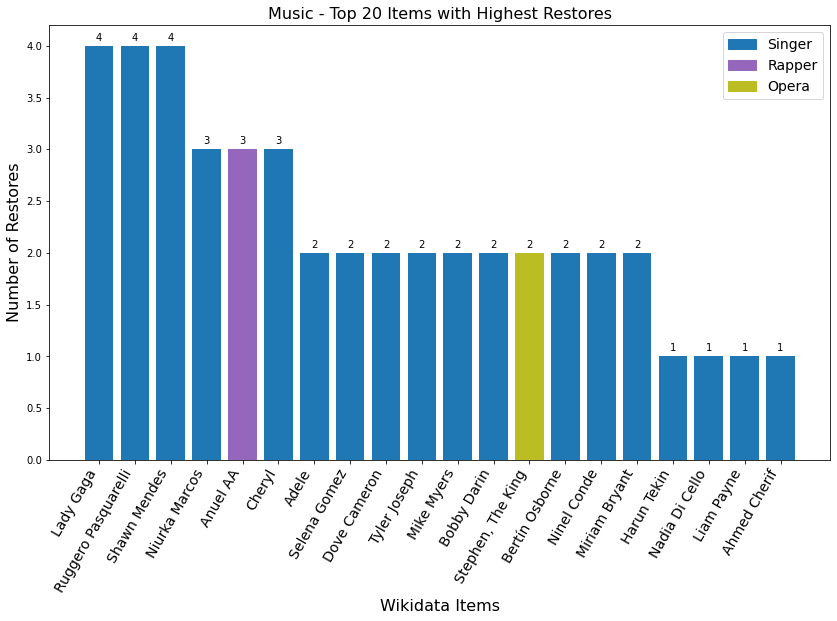

In [87]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

singer = mpatches.Patch(color='tab:blue', label='Singer')
rapper = mpatches.Patch(color='tab:purple', label='Rapper')
opera = mpatches.Patch(color='tab:olive', label='Opera')

plt.legend(handles=[singer, rapper, opera], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Music - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [88]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [89]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
5348,Q263696,0,0,1,0,1,17,168,44
785,Q130311,1,0,2,0,0,5,152,42
2998,Q6031433,0,1,1,0,0,11,147,16
720,Q108941,0,0,5,0,0,6,144,52
654,Q80938,0,1,31,0,0,6,114,17
345,Q1276,0,0,2,0,0,4,107,51
2480,Q4120122,21,0,1,4,0,4,100,10
1685,Q1275768,0,0,5,0,0,9,86,16
5475,Q277895,0,0,2,0,0,1,86,17
336,Q392,1,0,1,1,0,6,84,50


In [90]:
edit_item_labels = ['Debbie Reynolds', 'George Michael', 'Maddie Taylor', 'Carrie Fisher', 'John Travolta',
                     'Leonard Cohen', 'Ruggero Pasquarelli', 'Fred Rogers', 'Alan Thicke', 'Bob Dylan', 
                     'Tyler Joseph', 'Tim Curry', 'Jhon Kleiber', 'Michael Jackson', 'John Lennon',  
                     'John de Lancie', 'Lauren Jauregui', 'Tiffany Trump', 'Shawn Mendes', 'singer']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [91]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
5348,Q263696,Debbie Reynolds,0,0,1,0,1,17,168,44
785,Q130311,George Michael,1,0,2,0,0,5,152,42
2998,Q6031433,Maddie Taylor,0,1,1,0,0,11,147,16
720,Q108941,Carrie Fisher,0,0,5,0,0,6,144,52
654,Q80938,John Travolta,0,1,31,0,0,6,114,17
345,Q1276,Leonard Cohen,0,0,2,0,0,4,107,51
2480,Q4120122,Ruggero Pasquarelli,21,0,1,4,0,4,100,10
1685,Q1275768,Fred Rogers,0,0,5,0,0,9,86,16
5475,Q277895,Alan Thicke,0,0,2,0,0,1,86,17
336,Q392,Bob Dylan,1,0,1,1,0,6,84,50


Text(0.5, 1.0, 'Music - Top 20 Items with Highest Edits')

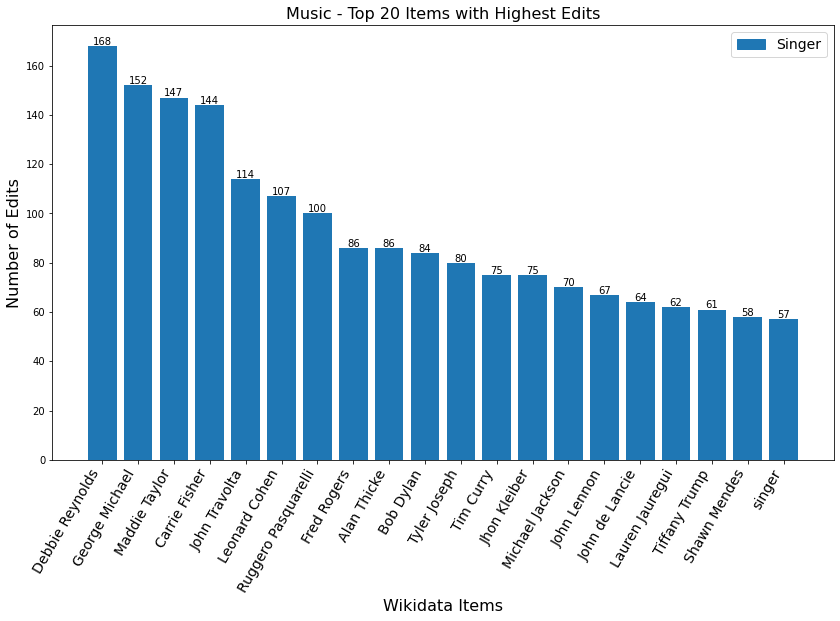

In [93]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

singer = mpatches.Patch(color='tab:blue', label='Singer')

plt.legend(handles=[singer], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Music - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [94]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [95]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
720,Q108941,0,0,5,0,0,6,144,52
345,Q1276,0,0,2,0,0,4,107,51
336,Q392,1,0,1,1,0,6,84,50
5348,Q263696,0,0,1,0,1,17,168,44
785,Q130311,1,0,2,0,0,5,152,42
3662,Q12071552,1,0,0,0,0,6,61,37
7954,Q27492272,0,1,0,0,0,0,54,29
363,Q2831,9,0,0,0,0,5,70,28
928,Q177220,4,0,3,1,0,1,57,27
4044,Q17306112,7,0,3,2,0,2,80,26


In [96]:
user_item_labels = ['Carrie Fisher', 'Leonard Cohen', 'Bob Dylan', 'Debbie Reynolds', 'George Michael',
                     'Tiffany Trump', 'Hovig Demirjian', 'Michael Jackson', 'singer', 'Tyler Joseph', 
                     'Elvis Presley', 'Park Ji-min', 'John Lennon', 'Steven Seagal', 'Blanche',  
                     'Florence Henderson', 'Madonna', 'Junaid Jamshed', 'Jungkook', 'Paul McCartney']

# Inserting item labels into restore proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [97]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
720,Q108941,Carrie Fisher,0,0,5,0,0,6,144,52
345,Q1276,Leonard Cohen,0,0,2,0,0,4,107,51
336,Q392,Bob Dylan,1,0,1,1,0,6,84,50
5348,Q263696,Debbie Reynolds,0,0,1,0,1,17,168,44
785,Q130311,George Michael,1,0,2,0,0,5,152,42
3662,Q12071552,Tiffany Trump,1,0,0,0,0,6,61,37
7954,Q27492272,Hovig Demirjian,0,1,0,0,0,0,54,29
363,Q2831,Michael Jackson,9,0,0,0,0,5,70,28
928,Q177220,singer,4,0,3,1,0,1,57,27
4044,Q17306112,Tyler Joseph,7,0,3,2,0,2,80,26


Text(0.5, 1.0, 'Music - Top 20 Items with Highest Users')

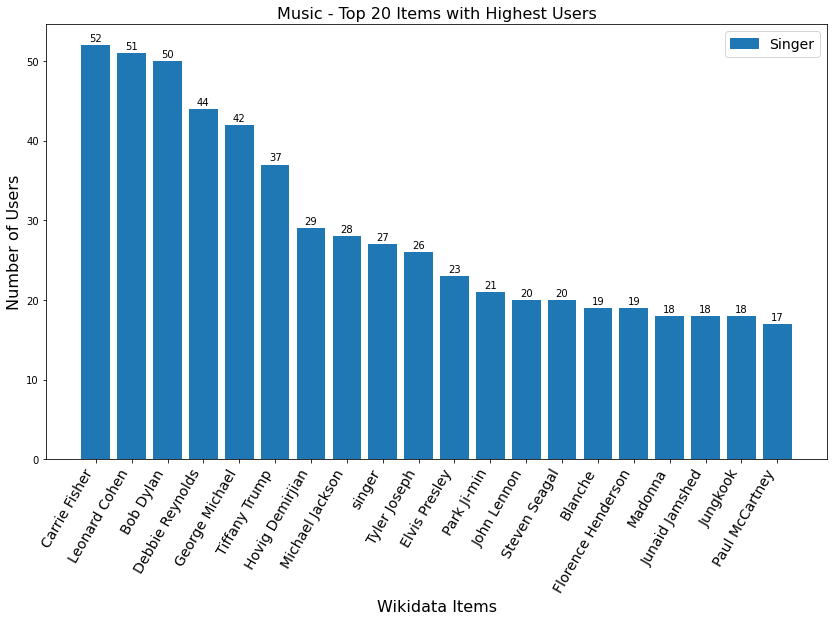

In [99]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

singer = mpatches.Patch(color='tab:blue', label='Singer')

plt.legend(handles=[singer], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Music - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [100]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [101]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q17306112    4
Q4120122     3
Q80938       3
Q17198340    3
Q177220      3
Q1203        3
Q2831        3
Q108941      3
Q19848       2
Q1276        2
Q12071552    2
Q1275768     2
Q550778      2
Q26690130    2
Q550067      2
Q303         2
Q392         2
Q130311      2
Q2709        2
Q263696      2
Name: qid, dtype: int64


The following items were selected:

- Q17306112 Tyler Joseph 
- Q1203	John Lennon 
- Q4120122	Ruggero Pasquarelli	
- Q19848	Lady Gaga
- Q80938	John Travolta

In [102]:
# Storing the revisions of the selected items in CSV files
rev[rev['qid'] == 'Q17306112'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/music/TylerJoseph_Q17306112.csv')
rev[rev['qid'] == 'Q1203'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/music/JohnLennon_Q1203.csv')
rev[rev['qid'] == 'Q4120122'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/music/RuggeroPasquarelli_Q4120122.csv')
rev[rev['qid'] == 'Q19848'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/music/LadyGaga_Q19848.csv')
rev[rev['qid'] == 'Q80938'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/music/JohnTravolta_Q80938.csv')